## 4- Daily Summary Table

How to import the daily summary table & demonstrations of what information it has.

Written by Jess Breda May 2023

### 1. Libraries

In [46]:
from create_summary_table import fetch_daily_summary_info

import seaborn as sns
import matplotlib.pyplot as plt

### 2. Fetch for a single animal

In [7]:
ANIMAL_ID = ["R610"]

r610_df = fetch_daily_summary_info(animal_ids=ANIMAL_ID, date_min="2023-05-15")

fetched 12 daily summaries for R610 between 2023-05-15 and 2023-05-26


In [8]:
r610_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   animal_id       12 non-null     object 
 1   date            12 non-null     object 
 2   rigid           12 non-null     object 
 3   n_done_trials   12 non-null     int64  
 4   n_sessions      12 non-null     int64  
 5   start_time      12 non-null     object 
 6   train_dur_hrs   12 non-null     float64
 7   trial_rate      12 non-null     float64
 8   mass            12 non-null     float64
 9   tech            12 non-null     object 
 10  percent_target  12 non-null     float64
 11  pub_volume      12 non-null     float64
 12  rig_volume      12 non-null     float64
 13  volume_target   12 non-null     float64
 14  water_diff      12 non-null     float64
dtypes: float64(8), int64(2), object(5)
memory usage: 1.5+ KB


In [9]:
r610_df.head()

,animal_id,date,rigid,n_done_trials,n_sessions,start_time,train_dur_hrs,trial_rate,mass,tech,percent_target,pub_volume,rig_volume,volume_target,water_diff
0,R610,2023-05-15,Rig406,68,1,10:15:52,0.39,174.36,16.98,ER,4.0,0.624,0.066,0.68,0.010
1,R610,2023-05-16,Rig406,177,1,09:50:40,1.03,171.84,16.96,JL,4.0,0.447,0.234,0.68,0.001
2,R610,2023-05-17,Rig406,160,1,07:37:16,1.03,155.34,16.89,ER,4.0,0.000,1.600,0.68,0.920
3,R610,2023-05-18,Rig406,152,1,07:51:08,1.02,149.02,17.01,ER,4.0,0.000,1.500,0.68,0.820
4,R610,2023-05-19,Rig406,191,1,07:50:52,1.01,189.11,17.29,ER,4.0,0.285,0.412,0.69,0.007


### 3. Visualize

In [10]:
# n done trials & rate

In [11]:
# mass

In [12]:
# water & pub

In [13]:
# tech / rig

### 4. Extensions

#### 4.1 Mega subplot

#### 4.2 Multiple animals

In [15]:
MULTIANIMAL_IDS = ["R610", "W600"]
mutlianimal_df = fetch_daily_summary_info(animal_ids=MULTIANIMAL_IDS, date_min="2023-05-15")

fetched 12 daily summaries for R610 between 2023-05-15 and 2023-05-26
rig volume wasn't tracked on 2023-05-19, defaulting to 0 mL
fetched 11 daily summaries for W600 between 2023-05-15 and 2023-05-26


In [17]:
mutlianimal_df.animal_id.unique()

array(['R610', 'W600'], dtype=object)

In [39]:
mutlianimal_df.groupby(["animal_id"]).trial_rate.mean()

animal_id
R610    175.640833
W600    321.472727
Name: trial_rate, dtype: float64

C:\Users\JB\AppData\Local\Temp\ipykernel_293740\2240203123.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


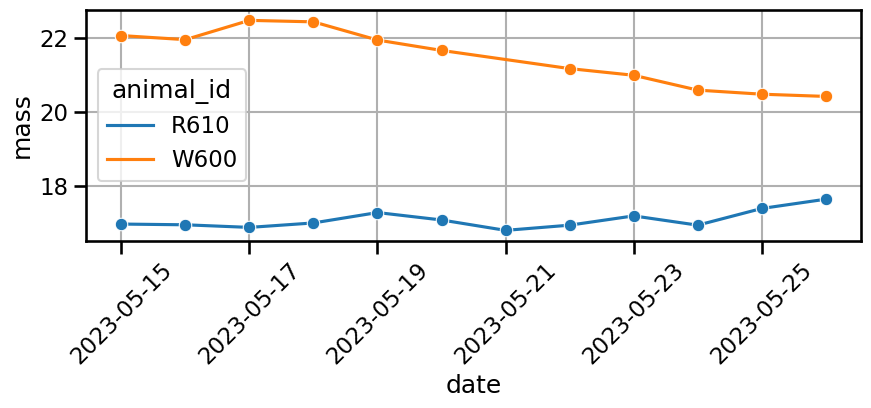

In [62]:
fig,ax = plt.subplots(1,1, figsize=(10,3))

sns.lineplot(data =mutlianimal_df, x="date", y="mass", hue="animal_id", marker="o", ax=ax)

ax.grid()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)



#### 4.3 Date window generator

#### 4.4 Overwrite checks